# Stroke Prediction ML

In [128]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, Perceptron
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import f_classif
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [130]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [131]:
data.head(10)

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   
5  56669    Male  81.0             0              0          Yes   
6  53882    Male  74.0             1              1          Yes   
7  10434  Female  69.0             0              0           No   
8  27419  Female  59.0             0              0          Yes   
9  60491  Female  78.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   
5        Private          Urban             186.21  29.0  formerly smoked   
6        Private          Rural              70.09  27.4     never smoked   
7        Private          Urban              94.39  22.8     never smoked   
8        Private          Rural              76.15   NaN          Unknown   
9        Private          Urban              58.57  24.2          Unknown   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1

# 1.Information of the dataset 

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [133]:
#return the missing rate of each column
def missing_rate(data):
    rate = {}
    for i in data.columns:
        rate[i] = data[i].isnull().sum() / len(data)
    return rate

#find the feature with missing rate
def missing_feature(rate):
    feature = []
    for i in rate.keys():
        if rate[i] != 0:
            feature.append(i)
    return feature

#find the features in each type
def feature_type(data):
    f_type = {}
    for i in data.columns:
        if f_type.get(data[i].dtype) == None:
            f_type[data[i].dtype] = [i]
        else:
            f_type[data[i].dtype].append(i)
    return f_type

In [134]:
missing_rate = missing_rate(data)
print(f'Missing rate: {missing_rate}')

Missing rate: {'id': 0.0, 'gender': 0.0, 'age': 0.0, 'hypertension': 0.0, 'heart_disease': 0.0, 'ever_married': 0.0, 'work_type': 0.0, 'Residence_type': 0.0, 'avg_glucose_level': 0.0, 'bmi': 0.03933463796477495, 'smoking_status': 0.0, 'stroke': 0.0}


In [135]:
missing_feauture = missing_feature(missing_rate)
print(f'Missing feature: {missing_feauture}') 

Missing feature: ['bmi']


In [136]:
feature_type = feature_type(data)
print(f'Feature type: {feature_type}')

Feature type: {dtype('int64'): ['id', 'hypertension', 'heart_disease', 'stroke'], dtype('O'): ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], dtype('float64'): ['age', 'avg_glucose_level', 'bmi']}


In [137]:
data['stroke'].value_counts().to_frame()

stroke
0    4861
1     249

In [138]:
print(f'Data shape: {data.shape}')
ratio = len(data[data['stroke'] == 1]) / len(data)
print(f'Stroke ratio: {ratio}')

Data shape: (5110, 12)
Stroke ratio: 0.0487279843444227


Observation:
    1. The dataset is highly imbalanced, only 4.9% of the data is stroke
    2. There is no natural language data like user comments
    3. Missing rate is low, use average BMI to fill missing values.

# 2.Data Visualization

/var/folders/wz/247cvxk14vn09q_qtxf05j940000gn/T/ipykernel_8048/921760034.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='Blues')


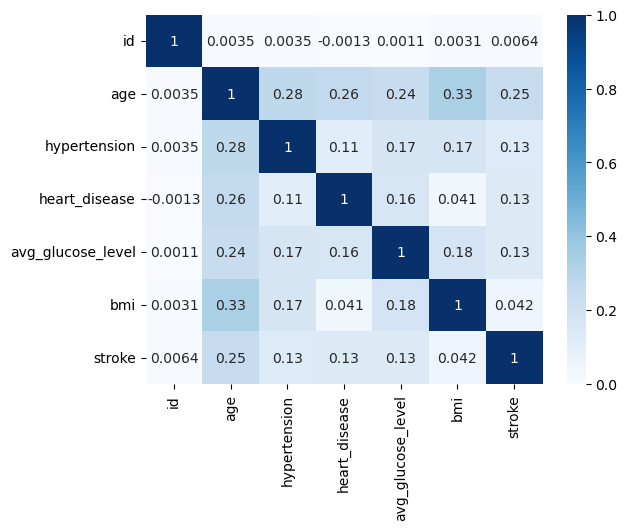

<Figure size 1600x1000 with 0 Axes>

In [139]:
sns.heatmap(data.corr(), annot=True, cmap='Blues')
plt.figure(figsize=(16,10))
plt.show()

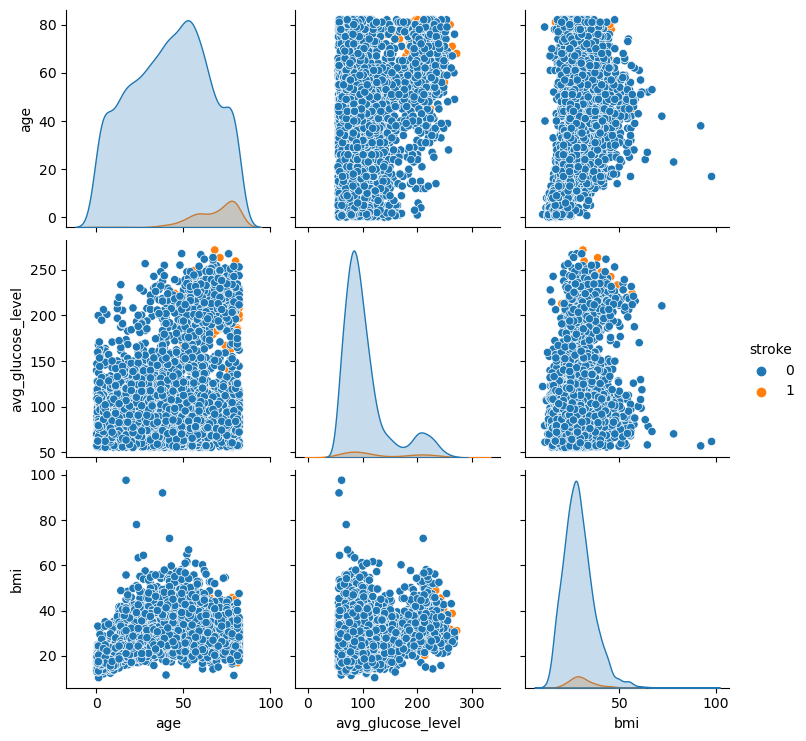

<Figure size 1600x1000 with 0 Axes>

In [140]:
sns.pairplot(data, vars = ['age','avg_glucose_level','bmi'], hue='stroke', diag_kind='kde')
plt.figure(figsize=(16,10))
plt.show()

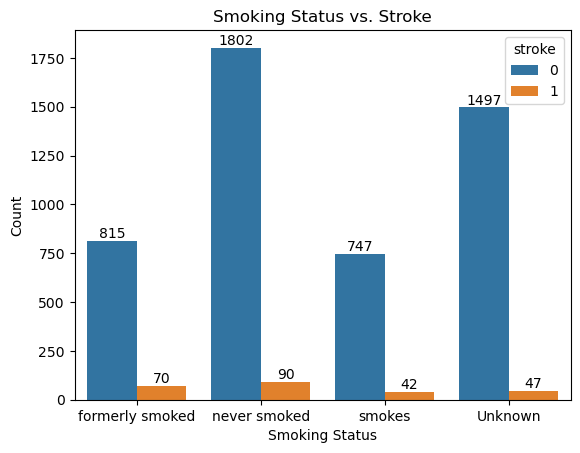

<Figure size 1000x800 with 0 Axes>

In [141]:
smoke = sns.countplot(x='smoking_status', hue='stroke', data=data)
for column in smoke.containers:
    smoke.bar_label(column)
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.title('Smoking Status vs. Stroke')
plt.figure(figsize=(10,8))
plt.show()

In [146]:
smoking_statu = data[data['smoking_status'].isin(['formerly smoked', 'smokes', 'never smoked'])]
smoking_table = pd.crosstab(smoking_statu['smoking_status'], smoking_statu['stroke'])
smoking_table.loc['total'] = smoking_table.sum(axis=0)
smoking_table['rate'] = round((smoking_table[1] / (smoking_table[0] + smoking_table[1])) *100,2)
smoking_table

stroke              0    1  rate
smoking_status                  
formerly smoked   815   70  7.91
never smoked     1802   90  4.76
smokes            747   42  5.32
total            3364  202  5.66

In [145]:
data['smoking_status'].isin(['formerly smoked', 'smokes', 'never smoked'])

0        True
1        True
2        True
3        True
4        True
        ...  
5105     True
5106     True
5107     True
5108     True
5109    False
Name: smoking_status, Length: 5110, dtype: bool

In [15]:
formerly_smoked = data[data['smoking_status'] == 'formerly smoked']
smokes = data[data['smoking_status'] == 'smokes']
age_formerly = np.mean(formerly_smoked['age']).round(2)
age_smokes = np.mean(smokes['age']).round(2)

formerly_stroke = formerly_smoked[formerly_smoked['stroke'] == 1]
smokes_stroke = smokes[smokes['stroke'] == 1]
age_formerly_stroke = np.mean(formerly_stroke['age']).round(2)
age_smokes_stroke = np.mean(smokes_stroke['age']).round(2)

print(f'The average age of formerly smoked people is {age_formerly} while the average age of smoked people is {age_smokes}')
print(f'The average age of formerly smoked people who have stroked is {age_formerly_stroke} while the average age of smoked people who have stroked is {age_smokes_stroke}')

The average age of formerly smoked people is 54.93 while the average age of smoked people is 47.1
The average age of formerly smoked people who have stroked is 68.63 while the average age of smoked people who have stroked is 62.81


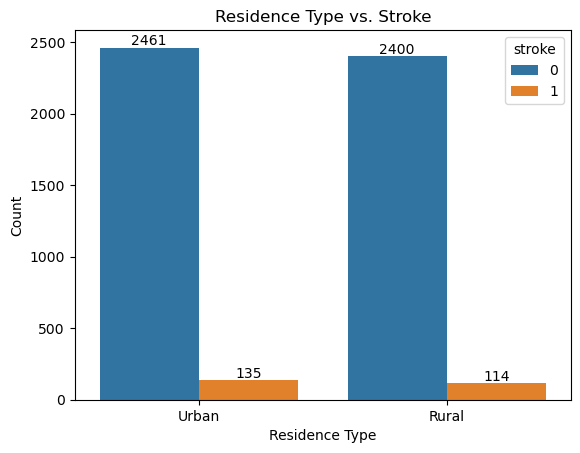

<Figure size 1000x800 with 0 Axes>

In [16]:
residence = sns.countplot(x='Residence_type', hue='stroke', data=data)
for column in residence.containers:
    residence.bar_label(column)
plt.xlabel('Residence Type')
plt.ylabel('Count')
plt.title('Residence Type vs. Stroke')
plt.figure(figsize=(10,8))
plt.show()

In [17]:
residence_type = pd.crosstab(data['Residence_type'], data['stroke'])
residence_type.loc['total'] = residence_type.sum(axis=0)
residence_type['rate'] = round((residence_type[1] / (residence_type[0] + residence_type[1])) *100,2)
residence_type

stroke             0    1  rate
Residence_type                 
Rural           2400  114  4.53
Urban           2461  135  5.20
total           4861  249  4.87

In [18]:
rural = data[data['Residence_type'] == 'Rural']
urban = data[data['Residence_type'] == 'Urban']
age_rural = np.mean(rural['age']).round(2)
age_urban = np.mean(urban['age']).round(2)

rural_stroke = rural[rural['stroke'] == 1]
urban_stroke = urban[urban['stroke'] == 1]
age_rural_stroke = np.mean(rural_stroke['age']).round(2)
age_urban_stroke = np.mean(urban_stroke['age']).round(2)

print(f'The average age of rural people is {age_rural} while the average age of urban people is {age_urban}')
print(f'The average age of rural people who have stroked is {age_rural_stroke} while the average age of urban people who have stroked is {age_urban_stroke}')

The average age of rural people is 42.9 while the average age of urban people is 43.54
The average age of rural people who have stroked is 67.57 while the average age of urban people who have stroked is 67.86


# 3.Feature Engineering

In [19]:
data.drop(['id'],axis=1,inplace=True)

In [20]:
avg = data['bmi'].mean()
data['bmi'] = data['bmi'].fillna(avg).round(2)

for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category')

In [21]:
#remove the outliers
numerical_cols = data.select_dtypes(include=['float64']).columns
z_scores = np.abs(zscore(data[numerical_cols]))
thresold = 3
outliers = (z_scores > thresold).sum()
percentage_outliers = (outliers.sum() / len(data)) * 100
print(f'Number of outliers: {outliers}')
print(f'Percentage of outliers: {percentage_outliers}%')

Number of outliers: age                   0
avg_glucose_level    49
bmi                  59
dtype: int64
Percentage of outliers: 2.1135029354207435%


In [22]:
#the outliers are removed
merged = data.merge(z_scores, left_index=True, right_index=True).rename(columns = {'age_x':'age','avg_glucose_level_x':'avg_glucose_level','bmi_x':'bmi','age_y':'age_zscore','avg_glucose_level_y':'avg_glucose_level_zscore','bmi_y':'bmi_zscore'})
data_no_outliters = merged[~((merged['age_zscore'] > thresold) | (merged['avg_glucose_level_zscore'] > thresold) | (merged['bmi_zscore'] > thresold))]
data_no_outliters.drop(['age_zscore','avg_glucose_level_zscore','bmi_zscore'], axis=1, inplace=True)
data_no_outliters


/var/folders/wz/247cvxk14vn09q_qtxf05j940000gn/T/ipykernel_8048/1806195758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliters.drop(['age_zscore','avg_glucose_level_zscore','bmi_zscore'], axis=1, inplace=True)


gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level    bmi   smoking_status  stroke  
0             Urban             228.69  36.60  formerly smoked       1  
1             Rural             202.21  28.89     never smoked       1  
2             Rural             105.92  32.50     never smoked       1  
3             Urban             171.23  34.40           smokes       1  
4             Rural             174.12  24.00     never smoked       1  
...             ...                ...    ...              ...     ...  
5105          Urban              83.75  28.89     never smoked       0  
5106          Urban             125.20  40.00     never smoked       0  
5107          Rural              82.99  30.60     never smoked       0  
5108          Rural             166.29  25.60  formerly smoked       0  
5109          Urban              85.28  26.20          Unknown       0  

[5002 rows x 11 columns]

In [90]:
#resample
stroke = data[data['stroke'] == 1]
no_stroke = data[data['stroke'] == 0]
no_stroke_resample = resample(no_stroke,n_samples=550,replace=True,random_state=42)
df = pd.concat([no_stroke_resample, stroke])

In [91]:
df['stroke'].value_counts().to_frame()

stroke
0     550
1     249

In [92]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']
for column in numeric_features:
    df[column] = MinMaxScaler().fit_transform(df[column].values.reshape(-1, 1))

In [93]:
categories=["gender","ever_married","work_type","Residence_type","smoking_status"]
LE=LabelEncoder()
for i in categories:
    df[i]=LE.fit_transform(df[i])

# 4. ML Modeling

df = pd.get_dummies(df, columns=['gender', 'smoking_status'], prefix=['gender', 'smoking'])

In [94]:
X = df.drop('stroke', axis=1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train data shape is: ', X_train.shape)
print('Test data shape is: ', X_test.shape)
print('Ratio of y_train: ', y_train.value_counts()[1]/y_train.value_counts()[0])
print('Ratio of y_test: ', y_test.value_counts()[1]/y_test.value_counts()[0])

Train data shape is:  (639, 10)
Test data shape is:  (160, 10)
Ratio of y_train:  0.44243792325056436
Ratio of y_test:  0.4953271028037383


Logistic Regression

In [103]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

LR_accuracy_score = accuracy_score(y_test, y_pred)
LR_precision_score = precision_score(y_test, y_pred)
LR_recall_score = recall_score(y_test, y_pred)
LR_F1_Score = f1_score(y_test, y_pred, average='weighted')
LR_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy Score: {LR_accuracy_score}")
print(f"Precision Score: {LR_precision_score}")
print(f"Recall Score: {LR_recall_score}")
print(f"F1 Score (weighted): {LR_F1_Score}")
print(f"ROC-AUC: {LR_roc_auc}")

Accuracy Score: 0.78125
Precision Score: 0.7142857142857143
Recall Score: 0.5660377358490566
F1 Score (weighted): 0.7739327485380116
ROC-AUC: 0.836889437488979


In [107]:
LR_conf_matrix = confusion_matrix(y_test, y_pred)
LR_conf_matrix

array([[95, 12],
       [23, 30]])

K-Nearest Neighbors

In [109]:
KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

KNN_accuracy_score = accuracy_score(y_test, y_pred)
KNN_precision_score = precision_score(y_test, y_pred)
KNN_recall_score = recall_score(y_test, y_pred)
KNN_F1_Score = f1_score(y_test, y_pred, average='weighted')
KNN_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy Score: {KNN_accuracy_score}")
print(f"Precision Score: {KNN_precision_score}")
print(f"Recall Score: {KNN_recall_score}")
print(f"F1 Score (weighted): {KNN_F1_Score}")
print(f"ROC-AUC: {KNN_roc_auc}")

Accuracy Score: 0.68125
Precision Score: 0.5454545454545454
Recall Score: 0.22641509433962265
F1 Score (weighted): 0.6355408163265306
ROC-AUC: 0.836889437488979


In [110]:
KNN_conf_matrix = confusion_matrix(y_test, y_pred)
KNN_conf_matrix

array([[97, 10],
       [41, 12]])

Random Forest

In [111]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

RF_accuracy_score = accuracy_score(y_test, y_pred)
RF_precision_score = precision_score(y_test, y_pred)
RF_recall_score = recall_score(y_test, y_pred)
RF_F1_Score = f1_score(y_test, y_pred, average='weighted')
RF_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy Score: {RF_accuracy_score}")
print(f"Precision Score: {RF_precision_score}")
print(f"Recall Score: {RF_recall_score}")
print(f"F1 Score (weighted): {RF_F1_Score}")
print(f"ROC-AUC: {RF_roc_auc}")

Accuracy Score: 0.78125
Precision Score: 0.7045454545454546
Recall Score: 0.5849056603773585
F1 Score (weighted): 0.7755160417918728
ROC-AUC: 0.836889437488979


In [112]:
RF_conf_matrix = confusion_matrix(y_test, y_pred)
RF_conf_matrix

array([[94, 13],
       [22, 31]])

XG Boost

In [115]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

XGB_accuracy_score = accuracy_score(y_test, y_pred)
XGB_precision_score = precision_score(y_test, y_pred)
XGB_recall_score = recall_score(y_test, y_pred)
XGB_F1_Score = f1_score(y_test, y_pred, average='weighted')
XGB_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy Score: {XGB_accuracy_score}")
print(f"Precision Score: {XGB_precision_score}")
print(f"Recall Score: {XGB_recall_score}")
print(f"F1 Score (weighted): {XGB_F1_Score}")
print(f"ROC-AUC: {XGB_roc_auc}")

Accuracy Score: 0.81875
Precision Score: 0.74
Recall Score: 0.6981132075471698
F1 Score (weighted): 0.8173633170775357
ROC-AUC: 0.836889437488979


SVM Model

In [114]:
XGB_conf_matrix = confusion_matrix(y_test, y_pred)
XGB_conf_matrix

array([[94, 13],
       [16, 37]])

In [116]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

svm_accuracy_score = accuracy_score(y_test, y_pred)
svm_precision_score = precision_score(y_test, y_pred)
svm_recall_score = recall_score(y_test, y_pred)
svm_F1_Score = f1_score(y_test, y_pred, average='weighted')
svm_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy Score: {svm_accuracy_score}")
print(f"Precision Score: {svm_precision_score}")
print(f"Recall Score: {svm_recall_score}")
print(f"F1 Score (weighted): {svm_F1_Score}")
print(f"ROC-AUC: {svm_roc_auc}")

Accuracy Score: 0.7125
Precision Score: 0.6060606060606061
Recall Score: 0.37735849056603776
F1 Score (weighted): 0.6913560922281853
ROC-AUC: 0.836889437488979


In [117]:
svm_conf_matrix = confusion_matrix(y_test, y_pred)
svm_conf_matrix

array([[94, 13],
       [33, 20]])

In [147]:
Accuracy=[LR_accuracy_score*100,KNN_accuracy_score*100, RF_accuracy_score*100,svm_accuracy_score*100, XGB_accuracy_score*100]
Algorithm=['Logistic Regression','KNN','Random Forest','SVM','XGB']
f1_score=[LR_F1_Score*100,KNN_F1_Score*100, RF_F1_Score*100,svm_F1_Score*100, XGB_F1_Score*100]
roc_auc=[LR_roc_auc*100,KNN_roc_auc*100, RF_roc_auc*100,svm_roc_auc*100, XGB_roc_auc*100]
data={'Algorithm':Algorithm,'Accuracy':Accuracy,'F1_SCORE':f1_score,'ROC-AUC':roc_auc}
Report=pd.DataFrame(data=data)
Report

Algorithm  Accuracy   F1_SCORE    ROC-AUC
0  Logistic Regression    78.125  77.393275  83.688944
1                  KNN    68.125  63.554082  83.688944
2        Random Forest    78.125  77.551604  83.688944
3                  SVM    71.250  69.135609  83.688944
4                  XGB    81.875  81.736332  83.688944

In [148]:
print('XGB model gives the best accuracy')

XGB model gives the best accuracy
